In [1]:
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/flypew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from utils import Imputer, MainFeatureExtractor, SimpleStatisticsExtractor, GeoFeatureExtractor, UserFeatureExtractor
from utils import BagOfWordsExtractor, TargetEncodingExtractor, ALSEmbeddingExtractor

In [7]:
path = "data/"
data_start = pd.read_csv(path + 'train_events.csv')
video_start = pd.read_csv(path + 'video_info_v2.csv')
targets_start = pd.read_csv(path + 'train_targets.csv')

In [8]:
import warnings
warnings.filterwarnings('ignore')

events, features = Imputer().fit_transform(data_start, video_start, targets_start)

for extractor in [MainFeatureExtractor(), ALSEmbeddingExtractor(), BagOfWordsExtractor(), SimpleStatisticsExtractor(), GeoFeatureExtractor(), UserFeatureExtractor()]:
    events, features = extractor.fit_transform(events, features)

features.shape

Applying ALSEmbeddingExtractor...
Applying BagOfWords extractor...
Applying SimpleStatisticsExtractor...


(180012, 366)

In [9]:
features.describe()

,viewer_uid,travel_count,has_app_installed,has_other,has_android,has_windows,has_mac,has_ios,has_ipados,region_user_count_log,...,category_Лайфхаки_viewtime,category_Лайфхаки_views,category_Психология_viewtime,category_Психология_views,category_Люди и блоги_viewtime,category_Люди и блоги_views,category_Охота и рыбалка_viewtime,category_Охота и рыбалка_views,category_Недвижимость_viewtime,category_Недвижимость_views
count,1.800120e+05,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,...,180012.000000,180012.00000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000,180012.000000
mean,1.029977e+07,1.642563,0.508449,0.046158,0.654467,0.292992,0.046430,0.087311,0.001583,11.041755,...,0.000918,0.00095,0.001138,0.001322,0.000377,0.000424,0.000441,0.000458,0.000157,0.000210
std,3.021522e+05,1.003531,0.499930,0.209828,0.475543,0.455136,0.210416,0.282291,0.039758,1.484634,...,0.025464,0.02438,0.028307,0.028017,0.016022,0.015794,0.018644,0.018077,0.010525,0.011116
min,1.000000e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.394449,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.006207e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.992414,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.016951e+07,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.164318,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.049191e+07,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,12.857973,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.114089e+07,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.857973,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
class CatboostEstimator:
    """
    Класс для обучения Catboost
    """

    def fit(self, X, y, ids, n_splits, cat_features, score):
        """
        Разбивает данные на k фолдов со стратификацией и обучает n_splits катбустов
        """
        self.one_model = False
        self.models = []
        scores = []
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for ind, (train_index, val_index) in enumerate(skf.split(X, y)):
            X_train = X.loc[train_index]
            y_train = y.loc[train_index]
            X_val = X.loc[val_index]
            y_val = y.loc[val_index]

            if y.name == 'age_class':
                train_idx = ids.loc[train_index]
                train_idx.name = 'viewer_uid'

                y_train_idx = y_train.copy()
                y_train_idx.index = train_idx
                X_train['viewer_uid'] = train_idx
                val_idx = ids.loc[val_index]
                val_idx.name = 'viewer_uid'
                X_val['viewer_uid'] = val_idx
                
                target_enc_ext = utils.TargetEncodingExtractor()
                events_filtered_train = pd.merge(events, train_idx, on='viewer_uid', how='inner')
                target_enc_ext.fit(events_filtered_train, pd.merge(X_train, y_train_idx, on='viewer_uid', how='inner'))
                events_filtered_test = pd.merge(events, val_idx, on='viewer_uid', how='inner')

                X_train = target_enc_ext.transform(events_filtered_train, X_train).drop(columns=['viewer_uid'])
                X_val = target_enc_ext.transform(events_filtered_test, X_val).drop(columns=['viewer_uid'])

            model = CatBoostClassifier(cat_features=cat_features, verbose=500, iterations=1000)
            model.fit(X_train, y_train, verbose=500, eval_set=(X_val, y_val))
            
            self.models.append(model)
            y_pred = model.predict(X_val)
            scores.append(score(y_val, y_pred))
            print(f'model {ind}: score = {round(scores[-1], 4)}')
        
        scores = np.array(scores)
        print(f'mean score = {scores.mean().round(4)}, std = {scores.std().round(4)}')
        print(f'overall score = {(scores.mean() - scores.std()).round(4)}')
            
    
    def fit_select_features(self, X, y, cat_features, to_drop):
        """
        Обучает один катбуст и выполняет elect features
        """
        self.one_model = True
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model = CatBoostClassifier(cat_features=cat_features, verbose=150, iterations=2000)
        
        self.model.select_features(X_train, y_train, verbose=500, eval_set=(X_val, y_val), steps=10,
                                  num_features_to_select=30, features_for_select=X.columns,
                                  algorithm='RecursiveByLossFunctionChange', train_final_model=True)

    def predict(self, X, cnt_classes):
        if self.one_model:
            return self.model.predict_proba(X)
        
        y_pred = np.zeros((X.shape[0], cnt_classes))

        for model in self.models:
            y_pred += model.predict_proba(X)
        y_pred /= cnt_classes
        y_pred = np.argmax(y_pred, axis=1)
        
        return y_pred

In [11]:
from sklearn.metrics import f1_score, accuracy_score

def score_sex(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def score_age(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

In [12]:
cat_features = []
for i, col in enumerate(features.columns):
    if features[col].dtype in ['object', 'category']:
        cat_features.append(col)
        
cat_features

['region', 'favourite_cat']

In [13]:
catboost_sex = CatboostEstimator()
catboost_age = CatboostEstimator()

features_to_drop = [
    'viewer_uid',
    'age'
]

target_sex = 'sex'
target_age = 'age_class'

print('Sex model\n')

ids = features.reset_index()['viewer_uid']
ids.name = 'viewer_uid'
y_sex = features[target_sex]
y_sex.name = target_sex

y_age = features[target_age]
y_age.name = target_age

catboost_sex.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_sex,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_sex)

print('\n\n\nAge model\n')

catboost_age.fit(features.drop(columns=features_to_drop + [target_sex] + [target_age]),
                 y_age,
                 ids,
                 n_splits=2,
                 cat_features=cat_features,
                 score=score_age)

Sex model

Learning rate set to 0.096297
0:	learn: 0.6672673	test: 0.6669559	best: 0.6669559 (0)	total: 104ms	remaining: 1m 44s
500:	learn: 0.4456678	test: 0.4895778	best: 0.4895191 (485)	total: 18.9s	remaining: 18.8s
999:	learn: 0.4041242	test: 0.4900053	best: 0.4892922 (720)	total: 36.8s	remaining: 0us

bestTest = 0.4892922045
bestIteration = 720

Shrink model to first 721 iterations.
model 0: score = 0.7593
Learning rate set to 0.096297
0:	learn: 0.6665696	test: 0.6671079	best: 0.6671079 (0)	total: 47.1ms	remaining: 47.1s
500:	learn: 0.4408914	test: 0.4942034	best: 0.4941426 (482)	total: 18.5s	remaining: 18.4s
999:	learn: 0.3996590	test: 0.4933879	best: 0.4933256 (646)	total: 36.4s	remaining: 0us

bestTest = 0.4933255938
bestIteration = 646

Shrink model to first 647 iterations.
model 1: score = 0.7546
mean score = 0.7569, std = 0.0024
overall score = 0.7546



Age model

Learning rate set to 0.118144
0:	learn: 1.3352297	test: 1.3361499	best: 1.3361499 (0)	total: 139ms	remaining: 2m

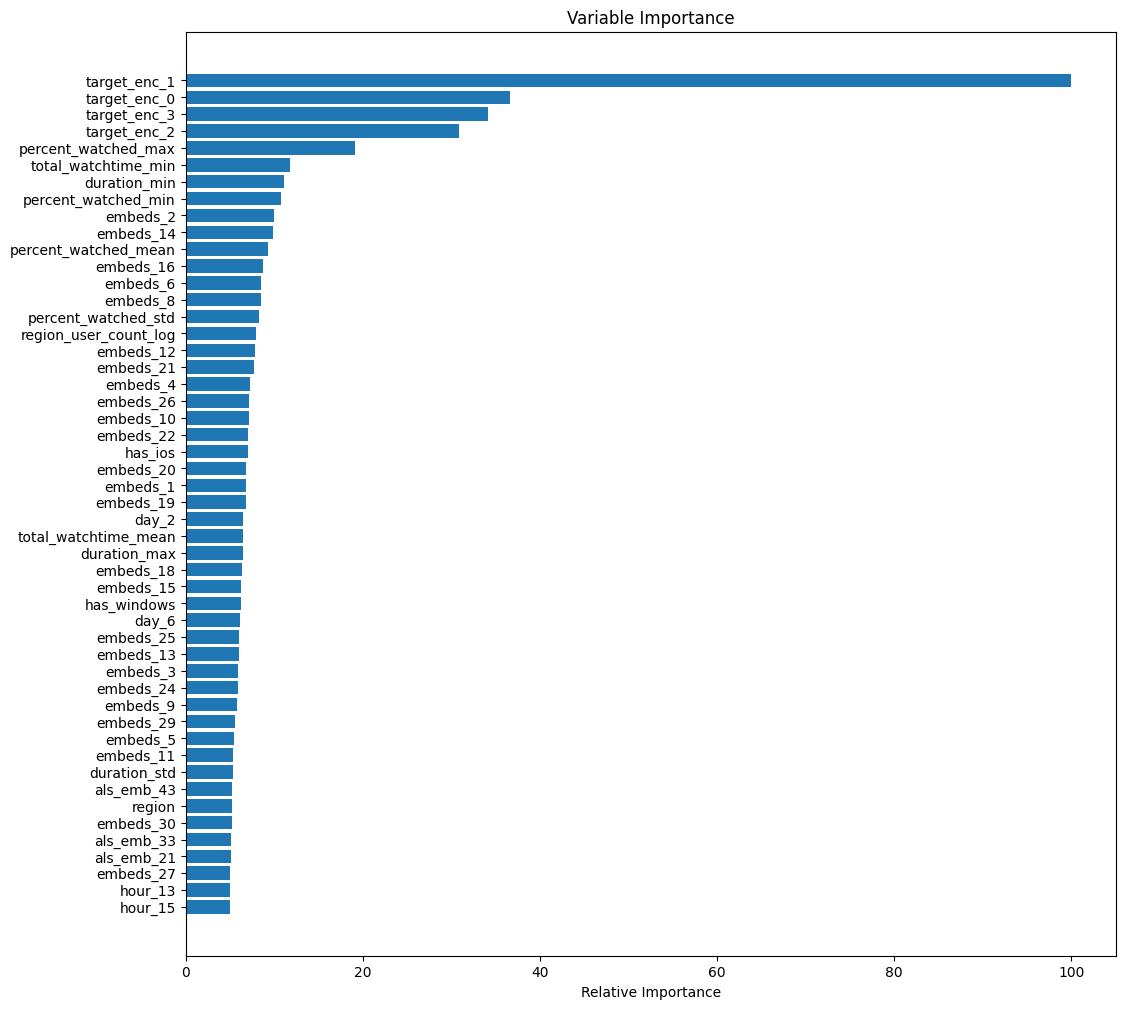

In [16]:
def plot_importance(model, features, top=50):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    cols = features.columns.to_list()
    cols = [f"target_enc_{i}" for i in range(len(sorted_idx) - len(cols))] + cols
    cols = np.array(cols)

    plt.figure(figsize=(12, 12))
    plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
    plt.yticks(pos[-top:], cols[sorted_idx][-top:])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
plot_importance(catboost_age.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))

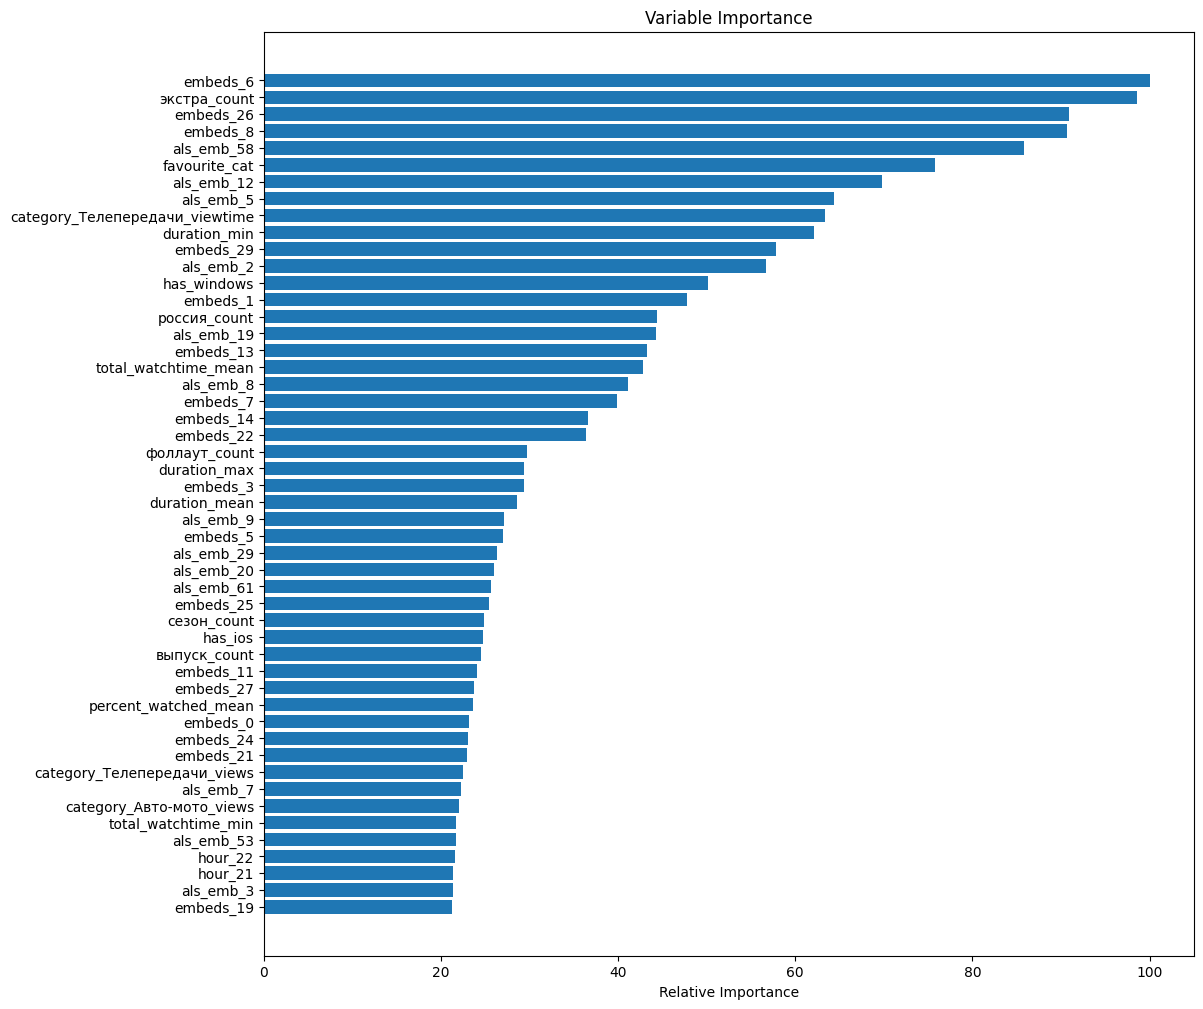

In [17]:
plot_importance(catboost_sex.models[0], features.drop(columns=features_to_drop + [target_sex] + [target_age]))